In [15]:
import numpy as np
import cv2
import glob

# Calibração Intrínseca da Câmera

Este notebook implementa a calibração intrínseca da câmera usando uma imagem de tabuleiro de xadrez 8x6.

A calibração de câmera é essencial para:
- Corrigir distorções da lente
- Obter parâmetros intrínsecos (matriz K)
- Permitir medições precisas no mundo real

## Parâmetros do tabuleiro:
- **Dimensões**: 8x6 cantos internos
- **Tamanho do quadrado**: será definido em unidades arbitrárias

Dimensões da imagem: (720, 1280, 3)


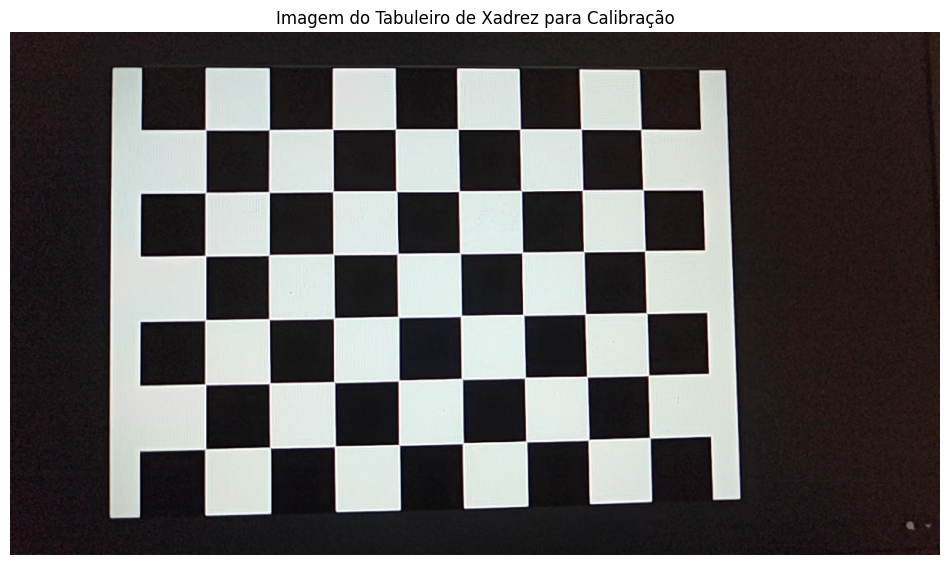

In [10]:
# Carregar e visualizar a imagem do tabuleiro
import matplotlib.pyplot as plt

# Carregar a imagem
img_path = 'IMG_20250910_18281108.jpeg'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"Dimensões da imagem: {img.shape}")

# Visualizar a imagem
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.title('Imagem do Tabuleiro de Xadrez para Calibração')
plt.axis('off')
plt.show()

In [11]:
# Configurar parâmetros do tabuleiro
pattern_size = (8, 6)  # 8x6 cantos internos
square_size = 1.0  # Tamanho do quadrado em unidades arbitrárias

# Preparar pontos do objeto (coordenadas 3D no mundo real)
objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
objp *= square_size

# Listas para armazenar pontos do objeto e pontos da imagem
objpoints = []  # Pontos 3D no mundo real
imgpoints = []  # Pontos 2D na imagem

print(f"Procurando padrão de {pattern_size[0]}x{pattern_size[1]} cantos...")
print(f"Coordenadas do objeto preparadas: {objp.shape}")

Procurando padrão de 8x6 cantos...
Coordenadas do objeto preparadas: (48, 3)


✓ Cantos do tabuleiro encontrados!


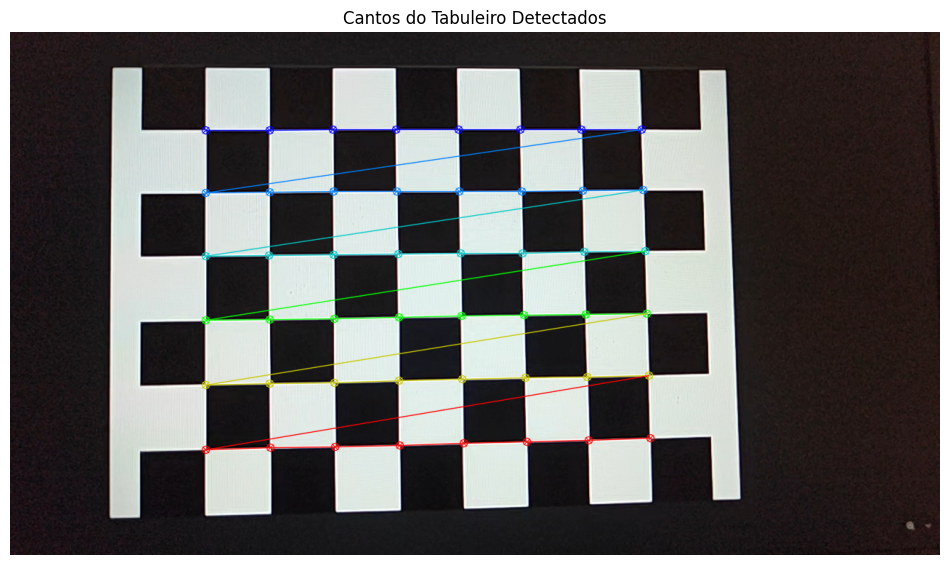

Número de cantos detectados: 48
Forma dos cantos: (48, 1, 2)


In [12]:
# Converter para escala de cinza
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Encontrar cantos do tabuleiro
ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

if ret:
    print("✓ Cantos do tabuleiro encontrados!")
    
    # Refinar os cantos
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
    
    # Adicionar pontos às listas
    objpoints.append(objp)
    imgpoints.append(corners2)
    
    # Desenhar e exibir os cantos
    img_with_corners = img_rgb.copy()
    cv2.drawChessboardCorners(img_with_corners, pattern_size, corners2, ret)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_with_corners)
    plt.title('Cantos do Tabuleiro Detectados')
    plt.axis('off')
    plt.show()
    
    print(f"Número de cantos detectados: {len(corners2)}")
    print(f"Forma dos cantos: {corners2.shape}")
    
else:
    print("✗ Não foi possível encontrar os cantos do tabuleiro!")
    print("Verifique se:")
    print("- A imagem contém um tabuleiro de xadrez")
    print("- O padrão especificado (8x6) está correto")
    print("- A imagem está bem iluminada e em foco")

In [13]:
# Realizar calibração da câmera
if len(objpoints) > 0:
    print("Realizando calibração da câmera...")
    
    # Calibrar câmera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    if ret:
        print("✓ Calibração realizada com sucesso!")
        print(f"Erro de reprojeção: {ret:.4f} pixels")
        
        # Matriz intrínseca (K)
        print("\n" + "="*50)
        print("MATRIZ INTRÍNSECA DA CÂMERA (K):")
        print("="*50)
        print(mtx)
        
        # Parâmetros individuais
        fx = mtx[0, 0]  # Distância focal em x
        fy = mtx[1, 1]  # Distância focal em y
        cx = mtx[0, 2]  # Centro óptico em x
        cy = mtx[1, 2]  # Centro óptico em y
        
        print(f"\nParâmetros intrínsecos:")
        print(f"fx (distância focal em x): {fx:.2f}")
        print(f"fy (distância focal em y): {fy:.2f}")
        print(f"cx (centro óptico em x): {cx:.2f}")
        print(f"cy (centro óptico em y): {cy:.2f}")
        
        # Coeficientes de distorção
        print(f"\nCoeficientes de distorção:")
        print(f"k1, k2, p1, p2, k3 = {dist.ravel()}")
        
        # Salvar matriz intrínseca
        np.save('matriz_intrinseca.npy', mtx)
        np.save('coeficientes_distorcao.npy', dist)
        print(f"\n✓ Matriz intrínseca salva em 'matriz_intrinseca.npy'")
        print(f"✓ Coeficientes de distorção salvos em 'coeficientes_distorcao.npy'")
        
    else:
        print("✗ Falha na calibração da câmera!")
else:
    print("✗ Não há pontos suficientes para calibração!")

Realizando calibração da câmera...
✓ Calibração realizada com sucesso!
Erro de reprojeção: 0.2369 pixels

MATRIZ INTRÍNSECA DA CÂMERA (K):
[[949.97226758   0.         630.81760602]
 [  0.         949.47553139 356.35824094]
 [  0.           0.           1.        ]]

Parâmetros intrínsecos:
fx (distância focal em x): 949.97
fy (distância focal em y): 949.48
cx (centro óptico em x): 630.82
cy (centro óptico em y): 356.36

Coeficientes de distorção:
k1, k2, p1, p2, k3 = [ 2.70483610e-01 -2.91730294e+00  1.64325101e-05 -1.75389764e-03
  7.95198138e+00]

✓ Matriz intrínseca salva em 'matriz_intrinseca.npy'
✓ Coeficientes de distorção salvos em 'coeficientes_distorcao.npy'


Aplicando correção de distorção...


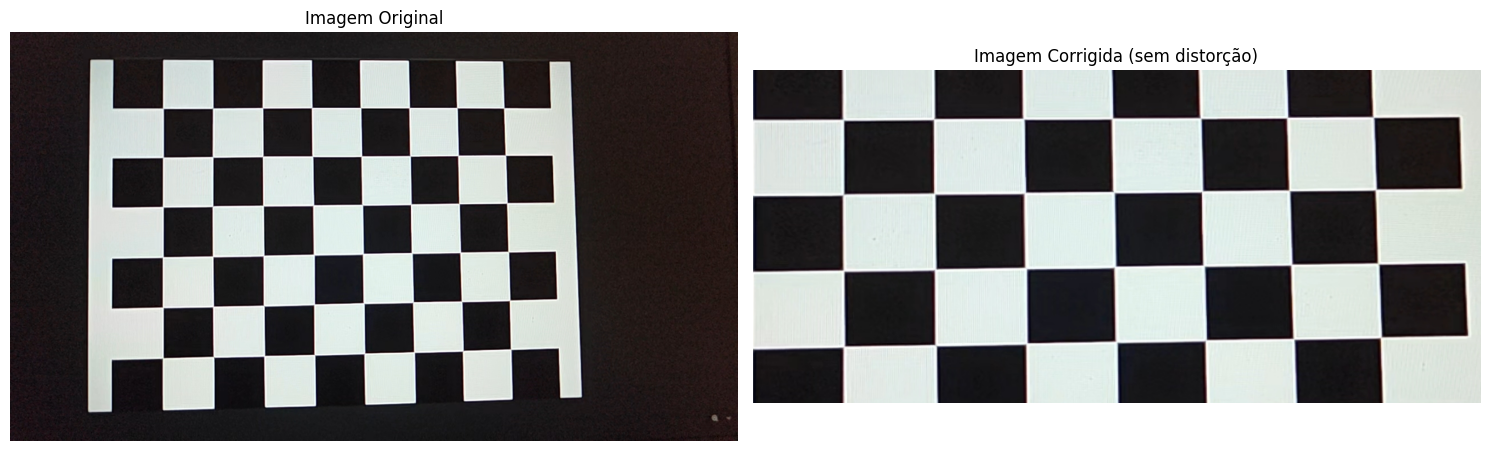

✓ Correção de distorção aplicada com sucesso!
✓ Nova matriz da câmera salva em 'nova_matriz_camera.npy'


In [14]:
# Demonstrar correção de distorção
if 'mtx' in locals() and 'dist' in locals():
    print("Aplicando correção de distorção...")
    
    # Obter região de interesse ótima
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    
    # Corrigir distorção
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    
    # Recortar a imagem
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    
    # Converter para RGB para exibição
    dst_rgb = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    
    # Comparar imagem original e corrigida
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.imshow(img_rgb)
    ax1.set_title('Imagem Original')
    ax1.axis('off')
    
    ax2.imshow(dst_rgb)
    ax2.set_title('Imagem Corrigida (sem distorção)')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Correção de distorção aplicada com sucesso!")
    
    # Salvar nova matriz da câmera
    np.save('nova_matriz_camera.npy', newcameramtx)
    print("✓ Nova matriz da câmera salva em 'nova_matriz_camera.npy'")